In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 15.5 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.75
batch_size_value = 64
n_repeats = 3
n_epochs = 50
lr = 1e-3
# noise = 'topological'
noise = 'salt&pepper'
# noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 0s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'gaussian':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:06<00:00, 1499.24it/s]



gaussian noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 1332.35it/s]


gaussian noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

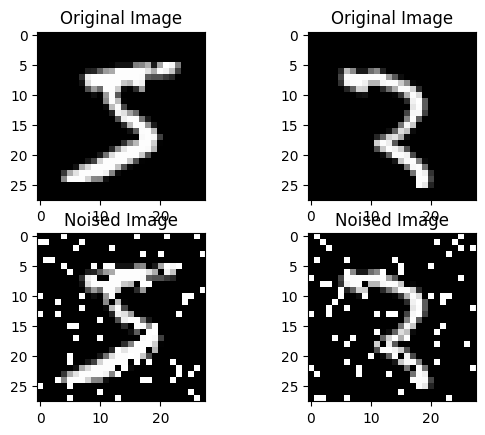

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

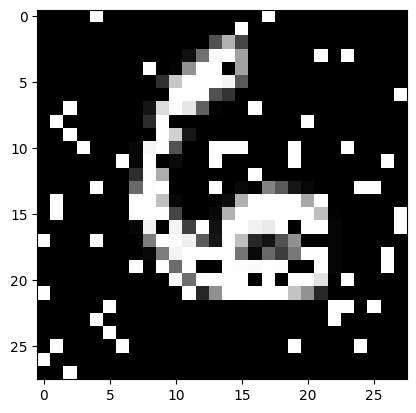

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

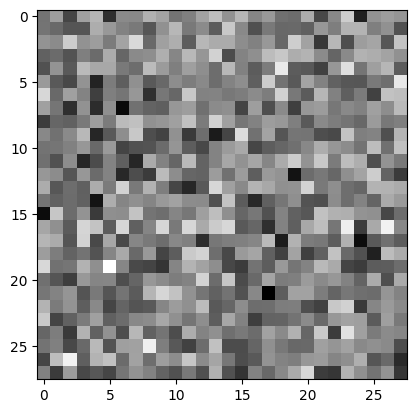

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(743.0777, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

5165.55615234375

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0156,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


  0 8342.1396 4872.2539


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


  1 7450.7334 4706.0850


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


  2 7066.4380 4609.1885


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


  3 6851.2295 4505.9609


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


  4 6790.2754 4334.9404


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


  5 6797.0288 4150.4658


100%|██████████| 157/157 [02:56<00:00,  1.12s/it]


  6 6858.1226 3904.7849


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


  7 6885.4761 3747.3455


100%|██████████| 157/157 [02:47<00:00,  1.07s/it]


  8 6915.4863 3621.8201


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


  9 6976.9883 3445.6040


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 10 6998.9409 3350.7468


100%|██████████| 157/157 [02:50<00:00,  1.08s/it]


 11 7031.3066 3252.5442


100%|██████████| 157/157 [02:50<00:00,  1.08s/it]


 12 7094.8486 3096.0081


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 13 7181.2578 2889.4766


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 14 7254.7036 2707.2783


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 15 7298.8936 2584.1389


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 16 7334.6367 2488.4250


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 17 7367.4062 2399.5103


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 18 7387.8760 2344.8604


100%|██████████| 157/157 [02:50<00:00,  1.08s/it]


 19 7399.8232 2302.7607


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 20 7408.7534 2270.8931


100%|██████████| 157/157 [02:50<00:00,  1.08s/it]


 21 7417.2993 2246.0518


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 22 7418.1099 2231.8398


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 23 7421.6211 2221.3000


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 24 7426.4658 2206.7273


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 25 7431.0894 2184.2644


100%|██████████| 157/157 [02:50<00:00,  1.08s/it]


 26 7438.5557 2166.0469


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 27 7440.6821 2154.1331


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 28 7447.5112 2134.0588


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 29 7453.9243 2113.8518


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 30 7456.8374 2103.0884


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 31 7453.2939 2107.5955


100%|██████████| 157/157 [02:50<00:00,  1.08s/it]


 32 7457.0034 2087.2922


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 33 7457.2793 2084.6628


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 34 7456.1177 2081.8076


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 35 7456.3804 2079.6060


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 36 7456.4429 2071.3950


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 37 7457.7021 2065.0242


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 38 7455.4922 2066.4565


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


 39 7455.0239 2066.6472


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 40 7455.6021 2056.9307


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 41 7454.1807 2054.6157


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 42 7457.0400 2044.3296


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 43 7458.0381 2042.8352


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 44 7454.2729 2040.1600


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 45 7457.3584 2030.5601


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 46 7457.7715 2024.8002


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 47 7455.8711 2029.9076


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 48 7454.6323 2023.3774


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 49 7454.4346 2018.1512

  2 MSE    Topo  


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


  0 8255.0928 4884.2080


100%|██████████| 157/157 [02:43<00:00,  1.04s/it]


  1 7397.7549 4672.0098


100%|██████████| 157/157 [02:44<00:00,  1.05s/it]


  2 7090.9473 4363.4194


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


  3 7136.2246 3874.3940


100%|██████████| 157/157 [02:48<00:00,  1.08s/it]


  4 7191.7188 3546.7969


100%|██████████| 157/157 [02:48<00:00,  1.08s/it]


  5 7278.8574 3220.0630


100%|██████████| 157/157 [02:50<00:00,  1.08s/it]


  6 7363.6631 2882.4187


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


  7 7382.1367 2722.5154


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


  8 7399.3936 2585.4316


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


  9 7426.9585 2474.6328


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 10 7439.6670 2380.6880


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 11 7436.1831 2345.5081


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


 12 7430.8774 2319.5039


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 13 7430.2754 2284.8936


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 14 7445.5767 2223.0654


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 15 7451.8281 2174.1084


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 16 7450.9585 2150.6968


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 17 7459.0820 2113.1902


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 18 7468.2275 2079.7847


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 19 7474.6479 2049.5498


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 20 7485.3120 2012.3296


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 21 7496.8662 1968.6871


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 22 7500.9795 1941.9211


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 23 7508.4761 1918.7942


100%|██████████| 157/157 [02:55<00:00,  1.11s/it]


 24 7513.7197 1897.8467


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 25 7511.3169 1885.4930


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 26 7511.8867 1878.7769


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 27 7511.3989 1872.8555


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 28 7509.1538 1870.8678


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 29 7512.4443 1855.4775


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 30 7511.7642 1849.8977


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 31 7508.2764 1847.8123


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 32 7504.7554 1842.3857


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 33 7499.4380 1846.2474


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 34 7491.7705 1846.9858


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 35 7490.0366 1837.3690


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 36 7487.4585 1837.0637


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 37 7484.9556 1831.0875


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 38 7486.9697 1824.4403


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 39 7481.0781 1826.1582


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 40 7482.8232 1818.7715


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 41 7476.0552 1825.9690


100%|██████████| 157/157 [02:50<00:00,  1.08s/it]


 42 7474.3760 1821.8730


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


 43 7473.1260 1820.8710


100%|██████████| 157/157 [02:50<00:00,  1.08s/it]


 44 7468.8979 1830.4438


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 45 7468.4521 1821.4119


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 46 7465.1211 1822.4016


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 47 7465.9282 1817.6926


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


 48 7466.5894 1809.9366


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 49 7462.8887 1810.1688

  3 MSE    Topo  


100%|██████████| 157/157 [02:44<00:00,  1.05s/it]


  0 8318.0068 4851.3740


100%|██████████| 157/157 [02:42<00:00,  1.04s/it]


  1 7422.7612 4673.7539


100%|██████████| 157/157 [02:43<00:00,  1.04s/it]


  2 7114.5698 4483.1108


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


  3 6989.3115 4377.2935


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


  4 6922.7285 4292.8013


100%|██████████| 157/157 [02:42<00:00,  1.04s/it]


  5 6855.6973 4223.5557


100%|██████████| 157/157 [02:43<00:00,  1.04s/it]


  6 6825.8760 4167.0869


100%|██████████| 157/157 [02:47<00:00,  1.07s/it]


  7 6813.5859 4115.2017


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


  8 6807.0557 4057.7620


100%|██████████| 157/157 [02:48<00:00,  1.08s/it]


  9 6798.4497 4005.2014


100%|██████████| 157/157 [02:44<00:00,  1.04s/it]


 10 6775.1904 3983.4387


100%|██████████| 157/157 [02:47<00:00,  1.07s/it]


 11 6771.4697 3943.7993


100%|██████████| 157/157 [02:44<00:00,  1.05s/it]


 12 6762.4648 3915.9766


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


 13 6777.5630 3851.9299


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


 14 6803.5464 3769.1792


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


 15 6823.2261 3698.4260


100%|██████████| 157/157 [02:43<00:00,  1.04s/it]


 16 6846.3198 3631.8616


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


 17 6873.5176 3564.8218


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


 18 6900.1846 3504.0254


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


 19 6932.3018 3428.1274


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 20 6956.1895 3378.0566


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 21 7083.3999 3122.3938


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


 22 7149.4561 2966.4490


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


 23 7232.4937 2774.9626


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


 24 7260.2134 2688.9292


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


 25 7276.1479 2641.5601


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


 26 7303.6162 2573.5134


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 27 7325.9126 2513.4653


100%|██████████| 157/157 [02:47<00:00,  1.07s/it]


 28 7330.5317 2492.2646


100%|██████████| 157/157 [02:47<00:00,  1.07s/it]


 29 7336.7300 2473.6497


100%|██████████| 157/157 [02:50<00:00,  1.08s/it]


 30 7342.3853 2458.8044


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 31 7359.4380 2411.5674


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 32 7368.1973 2386.9932


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 33 7371.8096 2362.6047


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


 34 7385.1870 2331.8293


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


 35 7403.8853 2283.1597


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


 36 7411.3677 2258.2290


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 37 7414.5806 2245.6550


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 38 7418.9839 2235.5979


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 39 7412.7979 2238.8467


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 40 7418.7881 2219.4829


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 41 7419.8804 2214.1504


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 42 7419.8271 2211.8831


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 43 7420.6001 2207.4316


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 44 7418.1265 2208.1504


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 45 7420.0464 2201.4331


100%|██████████| 157/157 [02:49<00:00,  1.08s/it]


 46 7420.1177 2192.9121


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 47 7418.0747 2194.1282


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 48 7422.6338 2185.3528


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]

 49 7422.7725 2180.9316

CPU times: user 13h 59min 7s, sys: 44.4 s, total: 13h 59min 52s
Wall time: 7h 5min 28s


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

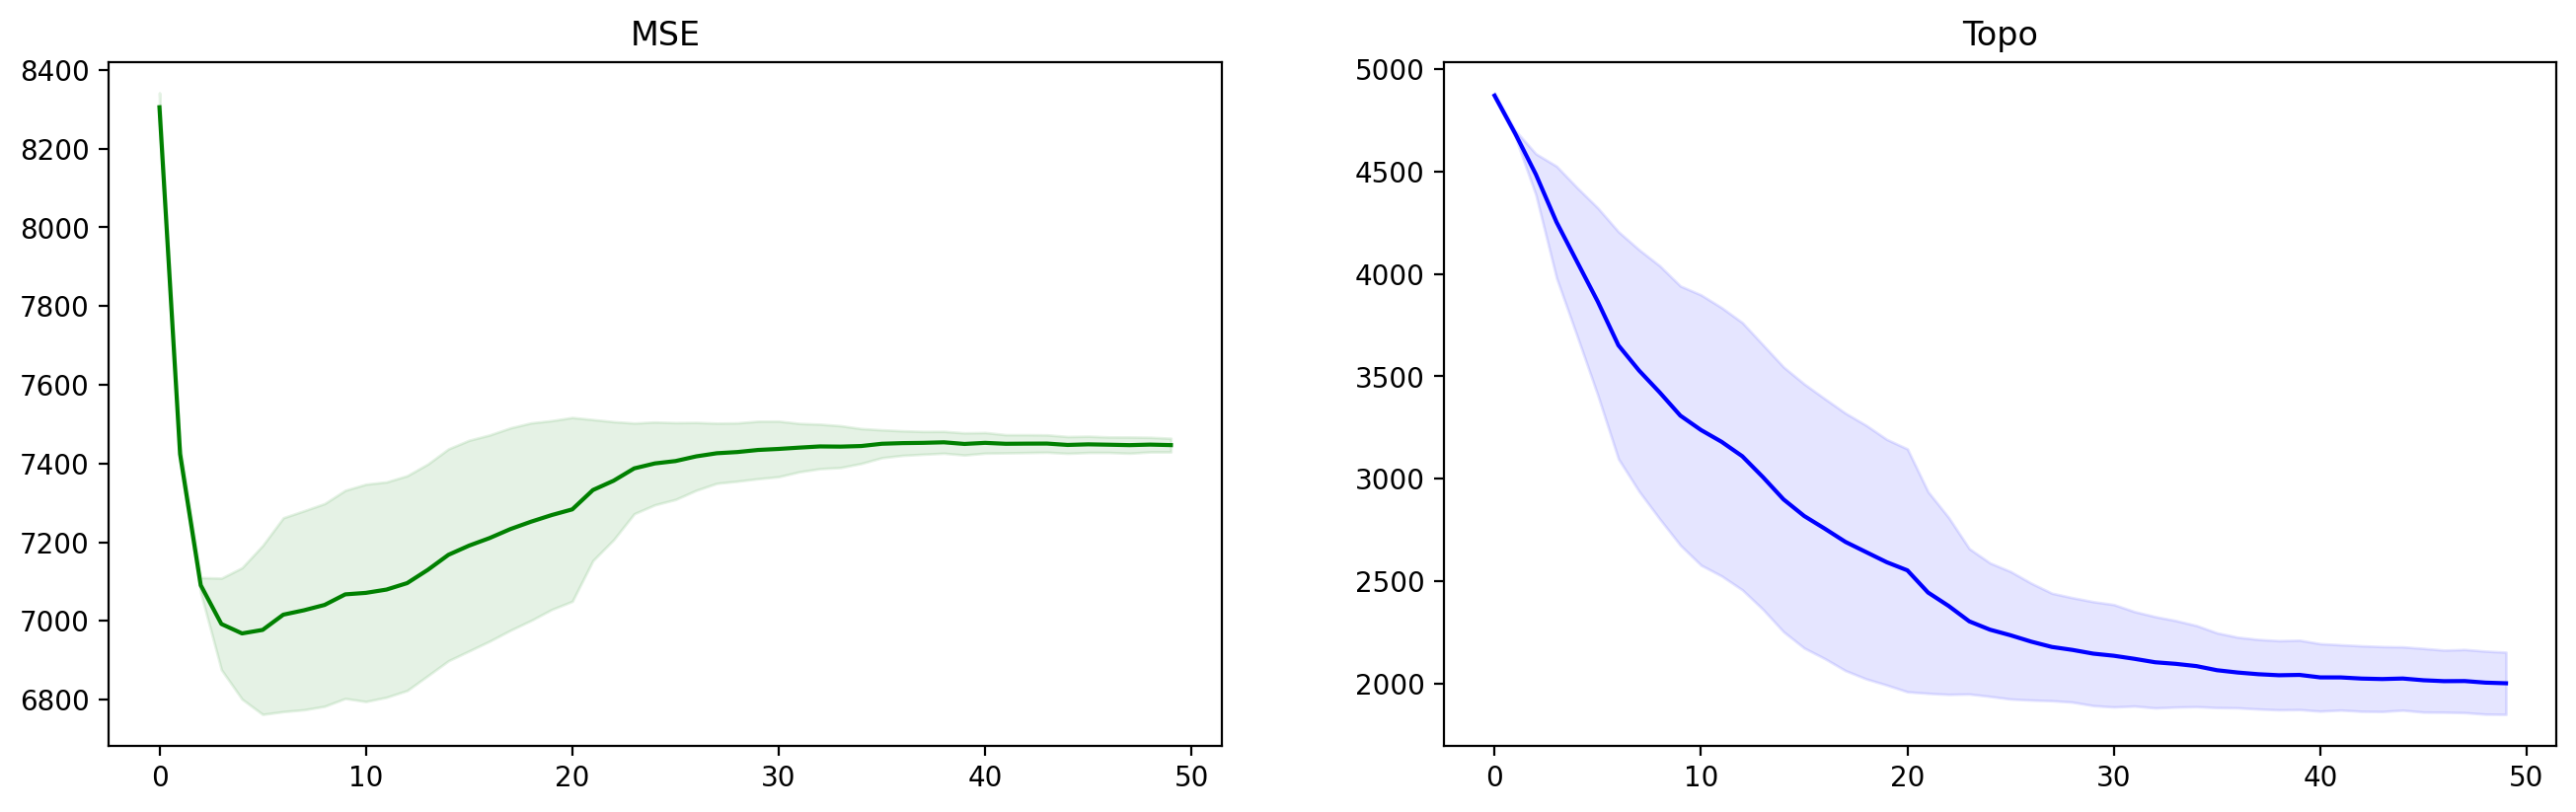

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

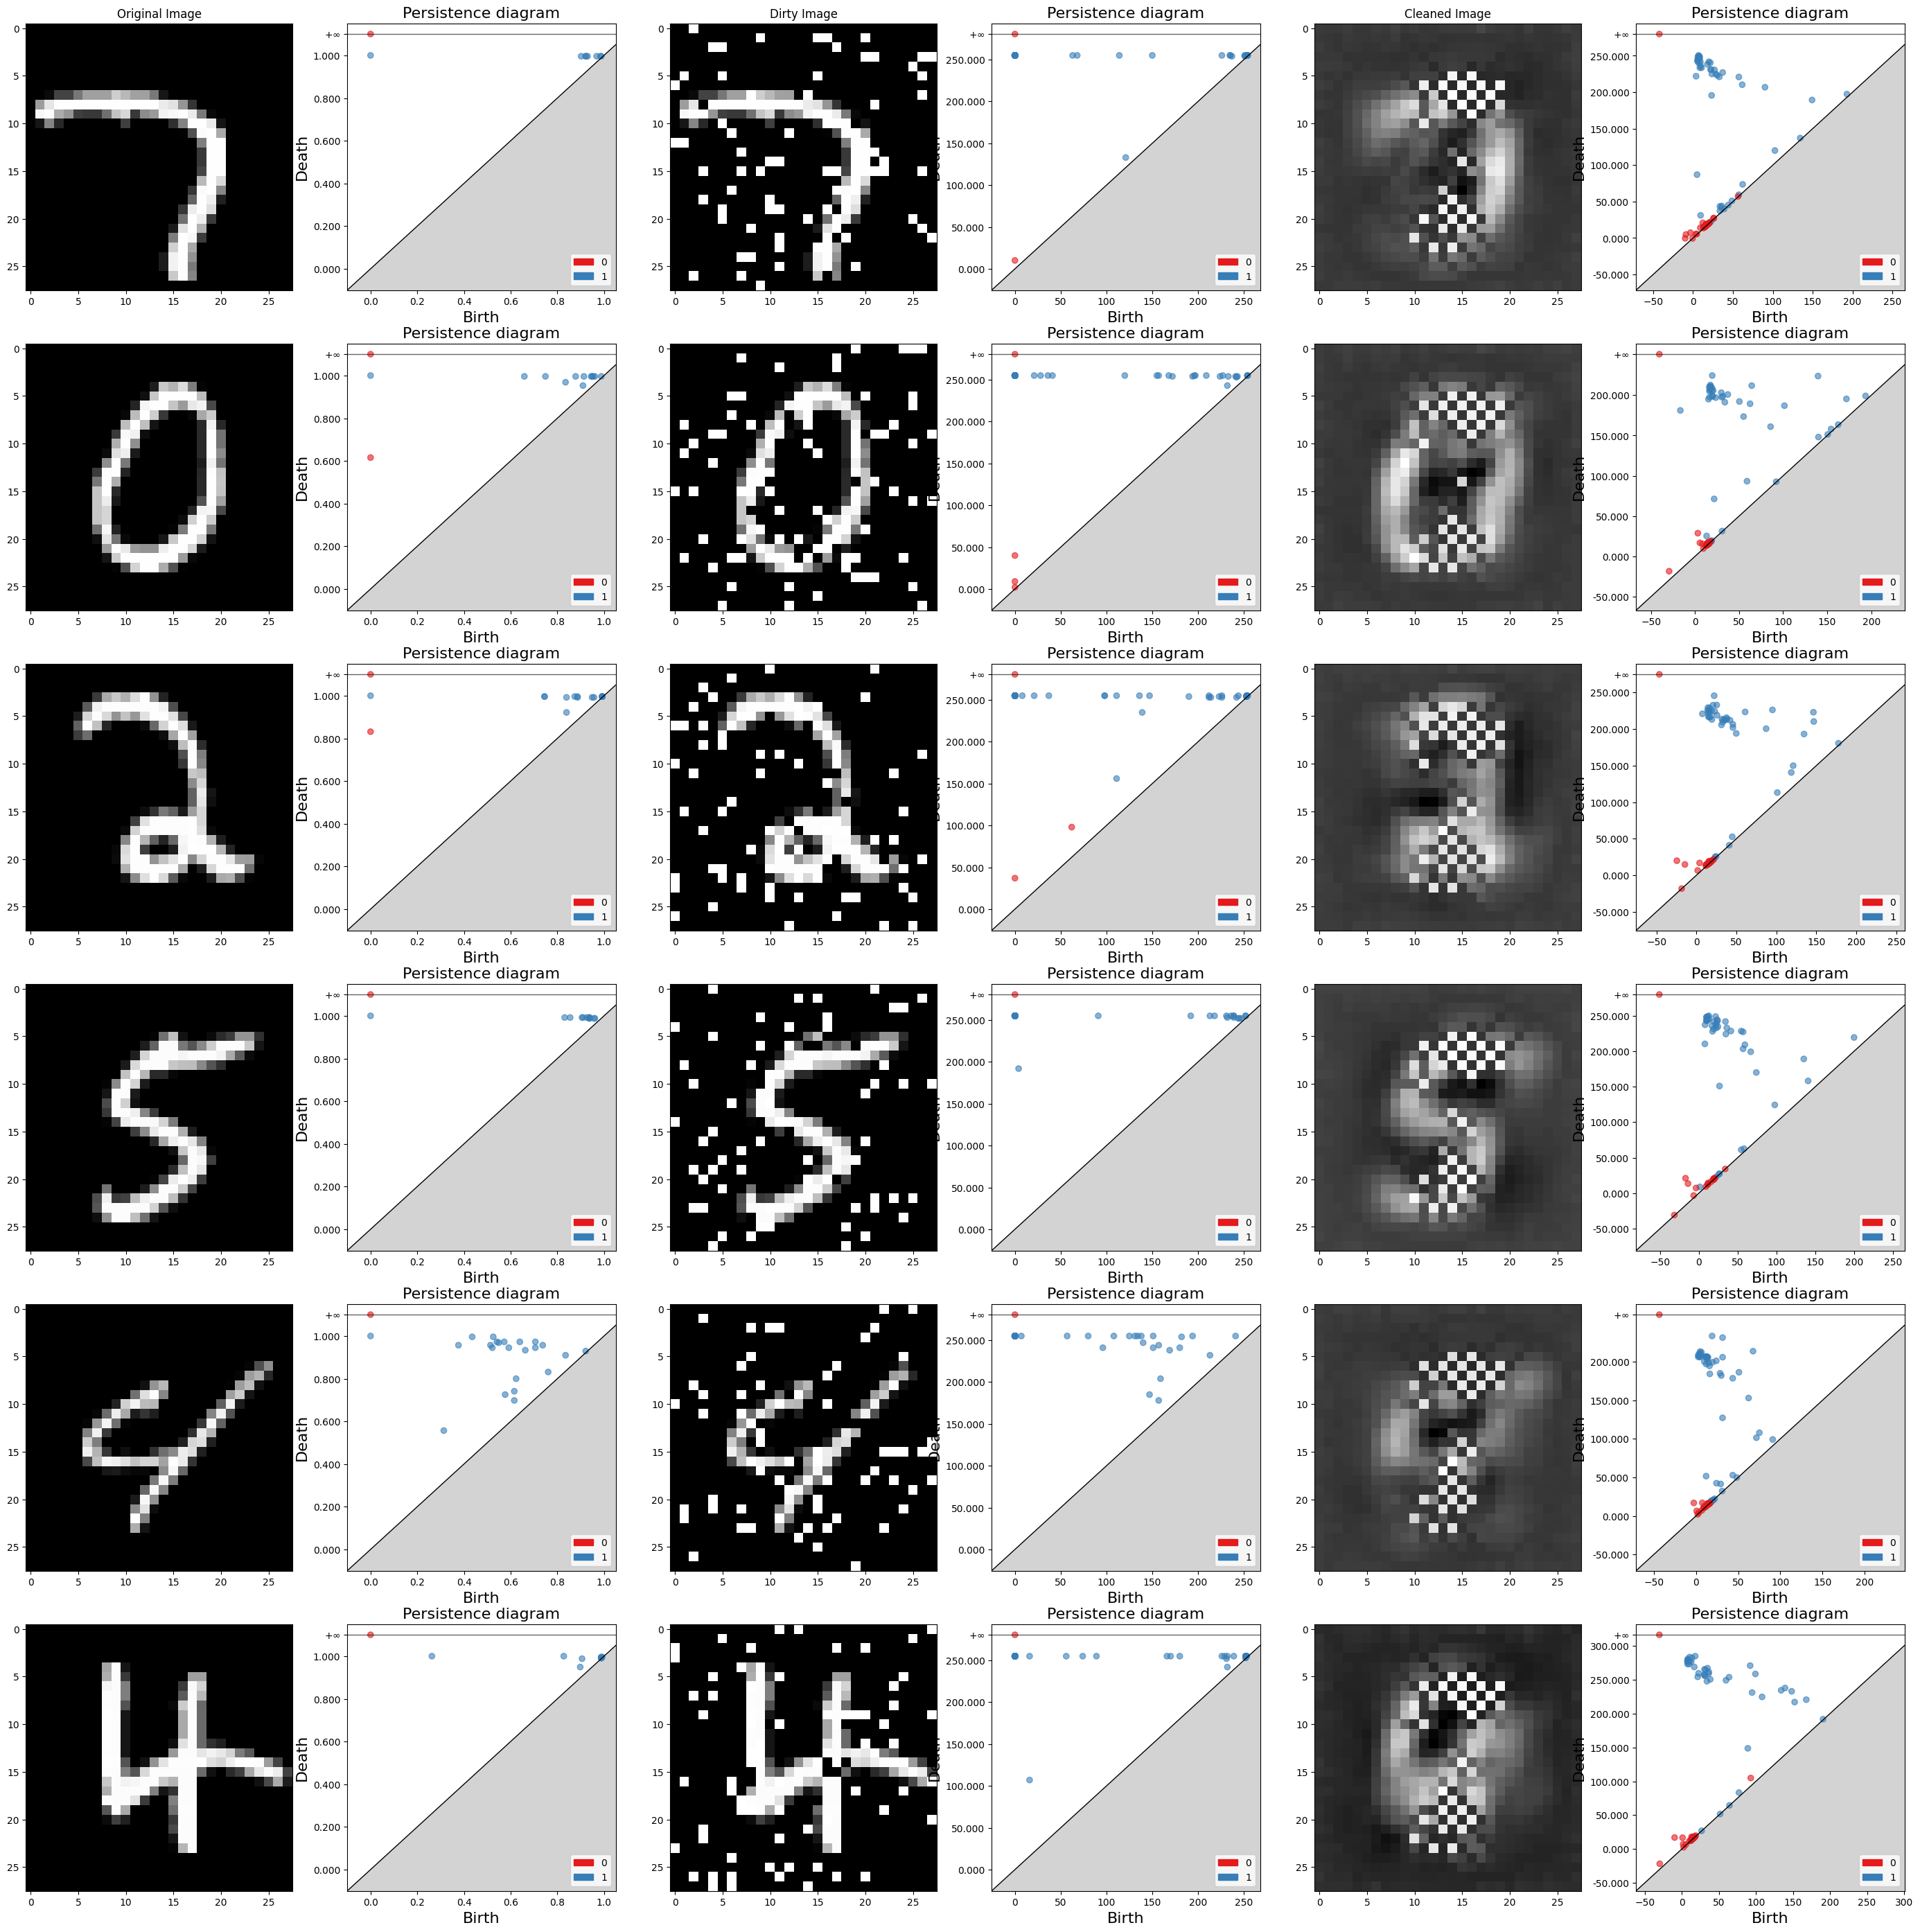

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[8342.13964844 4872.25390625]
  [7450.73339844 4706.08496094]
  [7066.43798828 4609.18847656]
  [6851.22949219 4505.9609375 ]
  [6790.27539062 4334.94042969]
  [6797.02880859 4150.46582031]
  [6858.12255859 3904.78491211]
  [6885.47607422 3747.34545898]
  [6915.48632812 3621.82006836]
  [6976.98828125 3445.60400391]
  [6998.94091797 3350.74682617]
  [7031.30664062 3252.54418945]
  [7094.84863281 3096.00805664]
  [7181.2578125  2889.4765625 ]
  [7254.70361328 2707.27832031]
  [7298.89355469 2584.13891602]
  [7334.63671875 2488.42504883]
  [7367.40625    2399.51025391]
  [7387.87597656 2344.86035156]
  [7399.82324219 2302.76074219]
  [7408.75341797 2270.89306641]
  [7417.29931641 2246.05175781]
  [7418.10986328 2231.83984375]
  [7421.62109375 2221.30004883]
  [7426.46582031 2206.72729492]
  [7431.08935547 2184.2644043 ]
  [7438.55566406 2166.046875  ]
  [7440.68212891 2154.13305664]
  [7447.51123047 2134.05883789]
  [7453.92431641 2113.85180664]
  [7456.83740234 2103.08837891]
  [7453.